In [3]:
import sys
sys.path.append('/Users/joy.chen/insitroRepos/posh_internal/common_utils') ## Adding path to common utils
sys.path.append('/Users/joy.chen/insitroRepos/posh_internal/core')


%load_ext autoreload
%autoreload 2

In [4]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
import database_utils as db_utils
import image_utils as img_utils

from skimage import exposure,filters,measure,segmentation

In [6]:

from insitro_core.pyxcell.utils import image, data, fluorescence, microscope
from insitro_core.pyxcell.type_definitions import ImageWithNamedChannels
from insitro_core.pyxcell.modules.segmentation import viz
from insitro_core.pyxcell.modules.segmentation.segmenters import cellpose_public
from insitro_core.pyxcell.modules.sequencing import fcn_base_caller, qc
from insitro_core.pyxcell.pipelines import registration

2023-08-17 14:44:35,272 [INFO] WRITING LOG OUTPUT TO /Users/joy.chen/.cellpose/run.log


In [7]:
plate_dir = "s3://insitro-microscopy-nikon-archive/nikon1/pyxscope/PA16732"

In [8]:
plate_id = 'PA16732'
microscope_id = 'nikon1_pyxscope'

#acqusition dataframe for ISS
list_of_measurementsDF = data.get_canonical_acquisitions(plate_id)
list_of_measurementsDF

2023-08-17 14:45:02,387 [INFO] Found credentials in shared credentials file: ~/.aws/credentials


,microscope_label,plate_barcode,measurement_id,measurement_datetime,total_images,channels
0,nikon1_pyxscope,PA16732,ff847a27-e584-4264-877e-652ccafc32f5,2023-06-05 22:52:03.695496,342,"[posh_a, posh_c, posh_g, posh_nucleus, posh_t]"
1,nikon1_pyxscope,PA16732,7fcf8111-9e3a-4ff4-9f8f-9f3dea7bf02d,2023-06-05 23:15:12.070631,342,"[posh_a, posh_c, posh_g, posh_nucleus, posh_t]"
2,nikon1_pyxscope,PA16732,485a0374-ef42-4172-b608-b428ede9e82a,2023-06-05 23:38:21.997798,342,"[posh_a, posh_c, posh_g, posh_nucleus, posh_t]"
3,nikon1_pyxscope,PA16732,61c28246-2d50-413d-b8b5-436d7fb7df07,2023-06-06 00:01:42.197633,342,"[posh_a, posh_c, posh_g, posh_nucleus, posh_t]"
4,nikon1_pyxscope,PA16732,594327fd-2d8b-4c9e-9090-d8d0f6b3f127,2023-06-06 00:24:34.706439,342,"[posh_a, posh_c, posh_g, posh_nucleus, posh_t]"
...,...,...,...,...,...,...
96,nikon1_pyxscope,PA16732,a0f603c3-2630-4ebc-a41d-816507f34464,2023-06-08 01:51:46.670327,342,"[posh_a, posh_c, posh_g, posh_nucleus, posh_t]"
97,nikon1_pyxscope,PA16732,cd39feaa-75e9-4bc1-865c-3fffb227d984,2023-06-08 02:16:14.995704,342,"[posh_a, posh_c, posh_g, posh_nucleus, posh_t]"
98,nikon1_pyxscope,PA16732,a0f5acfc-7d10-422e-a1fe-96db0f907c42,2023-06-08 02:40:45.553653,342,"[posh_a, posh_c, posh_g, posh_nucleus, posh_t]"
99,nikon1_pyxscope,PA16732,eda37d49-4891-482d-94d5-741a02c0e48c,2023-08-03 19:59:20.881566,51,[channel_0]


In [9]:
Manual_focus = list_of_measurementsDF.loc[list_of_measurementsDF["measurement_id"] == "eda37d49-4891-482d-94d5-741a02c0e48c"]

In [11]:
Manual_focus_measurement = Manual_focus['measurement_id'].values
MF_acquisition_df = data.create_multi_acquisition_canonical_dataframe(Manual_focus_measurement)
MF_acquisition_df

,id,microscope_id,measurement_id,file_path,raw_image_file_paths,time_index,plane_index,field_index,plate_barcode,well_row,...,measurement_datetime,observation_datetime,created_at_1,last_updated_at_1,exposure_time_milliseconds,index,channel_index,source_metadata_file_path,quadralateral_shearing_interferometry_modality_settings_id,well_loc
0,17383429,4,eda37d49-4891-482d-94d5-741a02c0e48c,s3://insitro-microscopy-data/prod/canonical/9e...,[s3://insitro-microscopy-nikon-archive/nikon1/...,0,0,0,PA16732,1,...,2023-08-03 19:59:20.881566,2023-08-03 19:59:20.881566,2023-08-03 20:06:58.030086,None,50.0035,0,0,s3://insitro-microscopy-nikon-archive/nikon1/p...,None,A01
1,17383430,4,eda37d49-4891-482d-94d5-741a02c0e48c,s3://insitro-microscopy-data/prod/canonical/ab...,[s3://insitro-microscopy-nikon-archive/nikon1/...,1,0,1,PA16732,1,...,2023-08-03 19:59:21.824566,2023-08-03 19:59:21.824566,2023-08-03 20:06:58.030089,None,50.0035,0,0,s3://insitro-microscopy-nikon-archive/nikon1/p...,None,A01
2,17383431,4,eda37d49-4891-482d-94d5-741a02c0e48c,s3://insitro-microscopy-data/prod/canonical/f9...,[s3://insitro-microscopy-nikon-archive/nikon1/...,2,0,2,PA16732,1,...,2023-08-03 19:59:22.751566,2023-08-03 19:59:22.751566,2023-08-03 20:06:58.030092,None,50.0035,0,0,s3://insitro-microscopy-nikon-archive/nikon1/p...,None,A01
3,17383432,4,eda37d49-4891-482d-94d5-741a02c0e48c,s3://insitro-microscopy-data/prod/canonical/53...,[s3://insitro-microscopy-nikon-archive/nikon1/...,3,0,3,PA16732,1,...,2023-08-03 19:59:23.630566,2023-08-03 19:59:23.630566,2023-08-03 20:06:58.030093,None,50.0035,0,0,s3://insitro-microscopy-nikon-archive/nikon1/p...,None,A01
4,17383433,4,eda37d49-4891-482d-94d5-741a02c0e48c,s3://insitro-microscopy-data/prod/canonical/f4...,[s3://insitro-microscopy-nikon-archive/nikon1/...,4,0,4,PA16732,1,...,2023-08-03 19:59:25.054566,2023-08-03 19:59:25.054566,2023-08-03 20:06:58.030095,None,50.0035,0,0,s3://insitro-microscopy-nikon-archive/nikon1/p...,None,A01
5,17383434,4,eda37d49-4891-482d-94d5-741a02c0e48c,s3://insitro-microscopy-data/prod/canonical/28...,[s3://insitro-microscopy-nikon-archive/nikon1/...,5,0,5,PA16732,1,...,2023-08-03 19:59:25.853566,2023-08-03 19:59:25.853566,2023-08-03 20:06:58.030096,None,50.0035,0,0,s3://insitro-microscopy-nikon-archive/nikon1/p...,None,A01
6,17383435,4,eda37d49-4891-482d-94d5-741a02c0e48c,s3://insitro-microscopy-data/prod/canonical/bc...,[s3://insitro-microscopy-nikon-archive/nikon1/...,6,0,6,PA16732,1,...,2023-08-03 19:59:26.764566,2023-08-03 19:59:26.764566,2023-08-03 20:06:58.030098,None,50.0035,0,0,s3://insitro-microscopy-nikon-archive/nikon1/p...,None,A01
7,17383436,4,eda37d49-4891-482d-94d5-741a02c0e48c,s3://insitro-microscopy-data/prod/canonical/d6...,[s3://insitro-microscopy-nikon-archive/nikon1/...,7,0,7,PA16732,1,...,2023-08-03 19:59:27.628566,2023-08-03 19:59:27.628566,2023-08-03 20:06:58.030099,None,50.0035,0,0,s3://insitro-microscopy-nikon-archive/nikon1/p...,None,A01
8,17383437,4,eda37d49-4891-482d-94d5-741a02c0e48c,s3://insitro-microscopy-data/prod/canonical/ff...,[s3://insitro-microscopy-nikon-archive/nikon1/...,8,0,8,PA16732,1,...,2023-08-03 19:59:28.603566,2023-08-03 19:59:28.603566,2023-08-03 20:06:58.030101,None,50.0035,0,0,s3://insitro-microscopy-nikon-archive/nikon1/p...,None,A01
9,17383438,4,eda37d49-4891-482d-94d5-741a02c0e48c,s3://insitro-microscopy-data/prod/canonical/0b...,[s3://insitro-microscopy-nikon-archive/nikon1/...,9,0,9,PA16732,1,...,2023-08-03 19:59:30.186566,2023-08-03 19:59:30.186566,2023-08-03 20:06:58.030102,None,50.0035,0,0,s3://insitro-microscopy-nikon-archive/nikon1/p...,None,A01


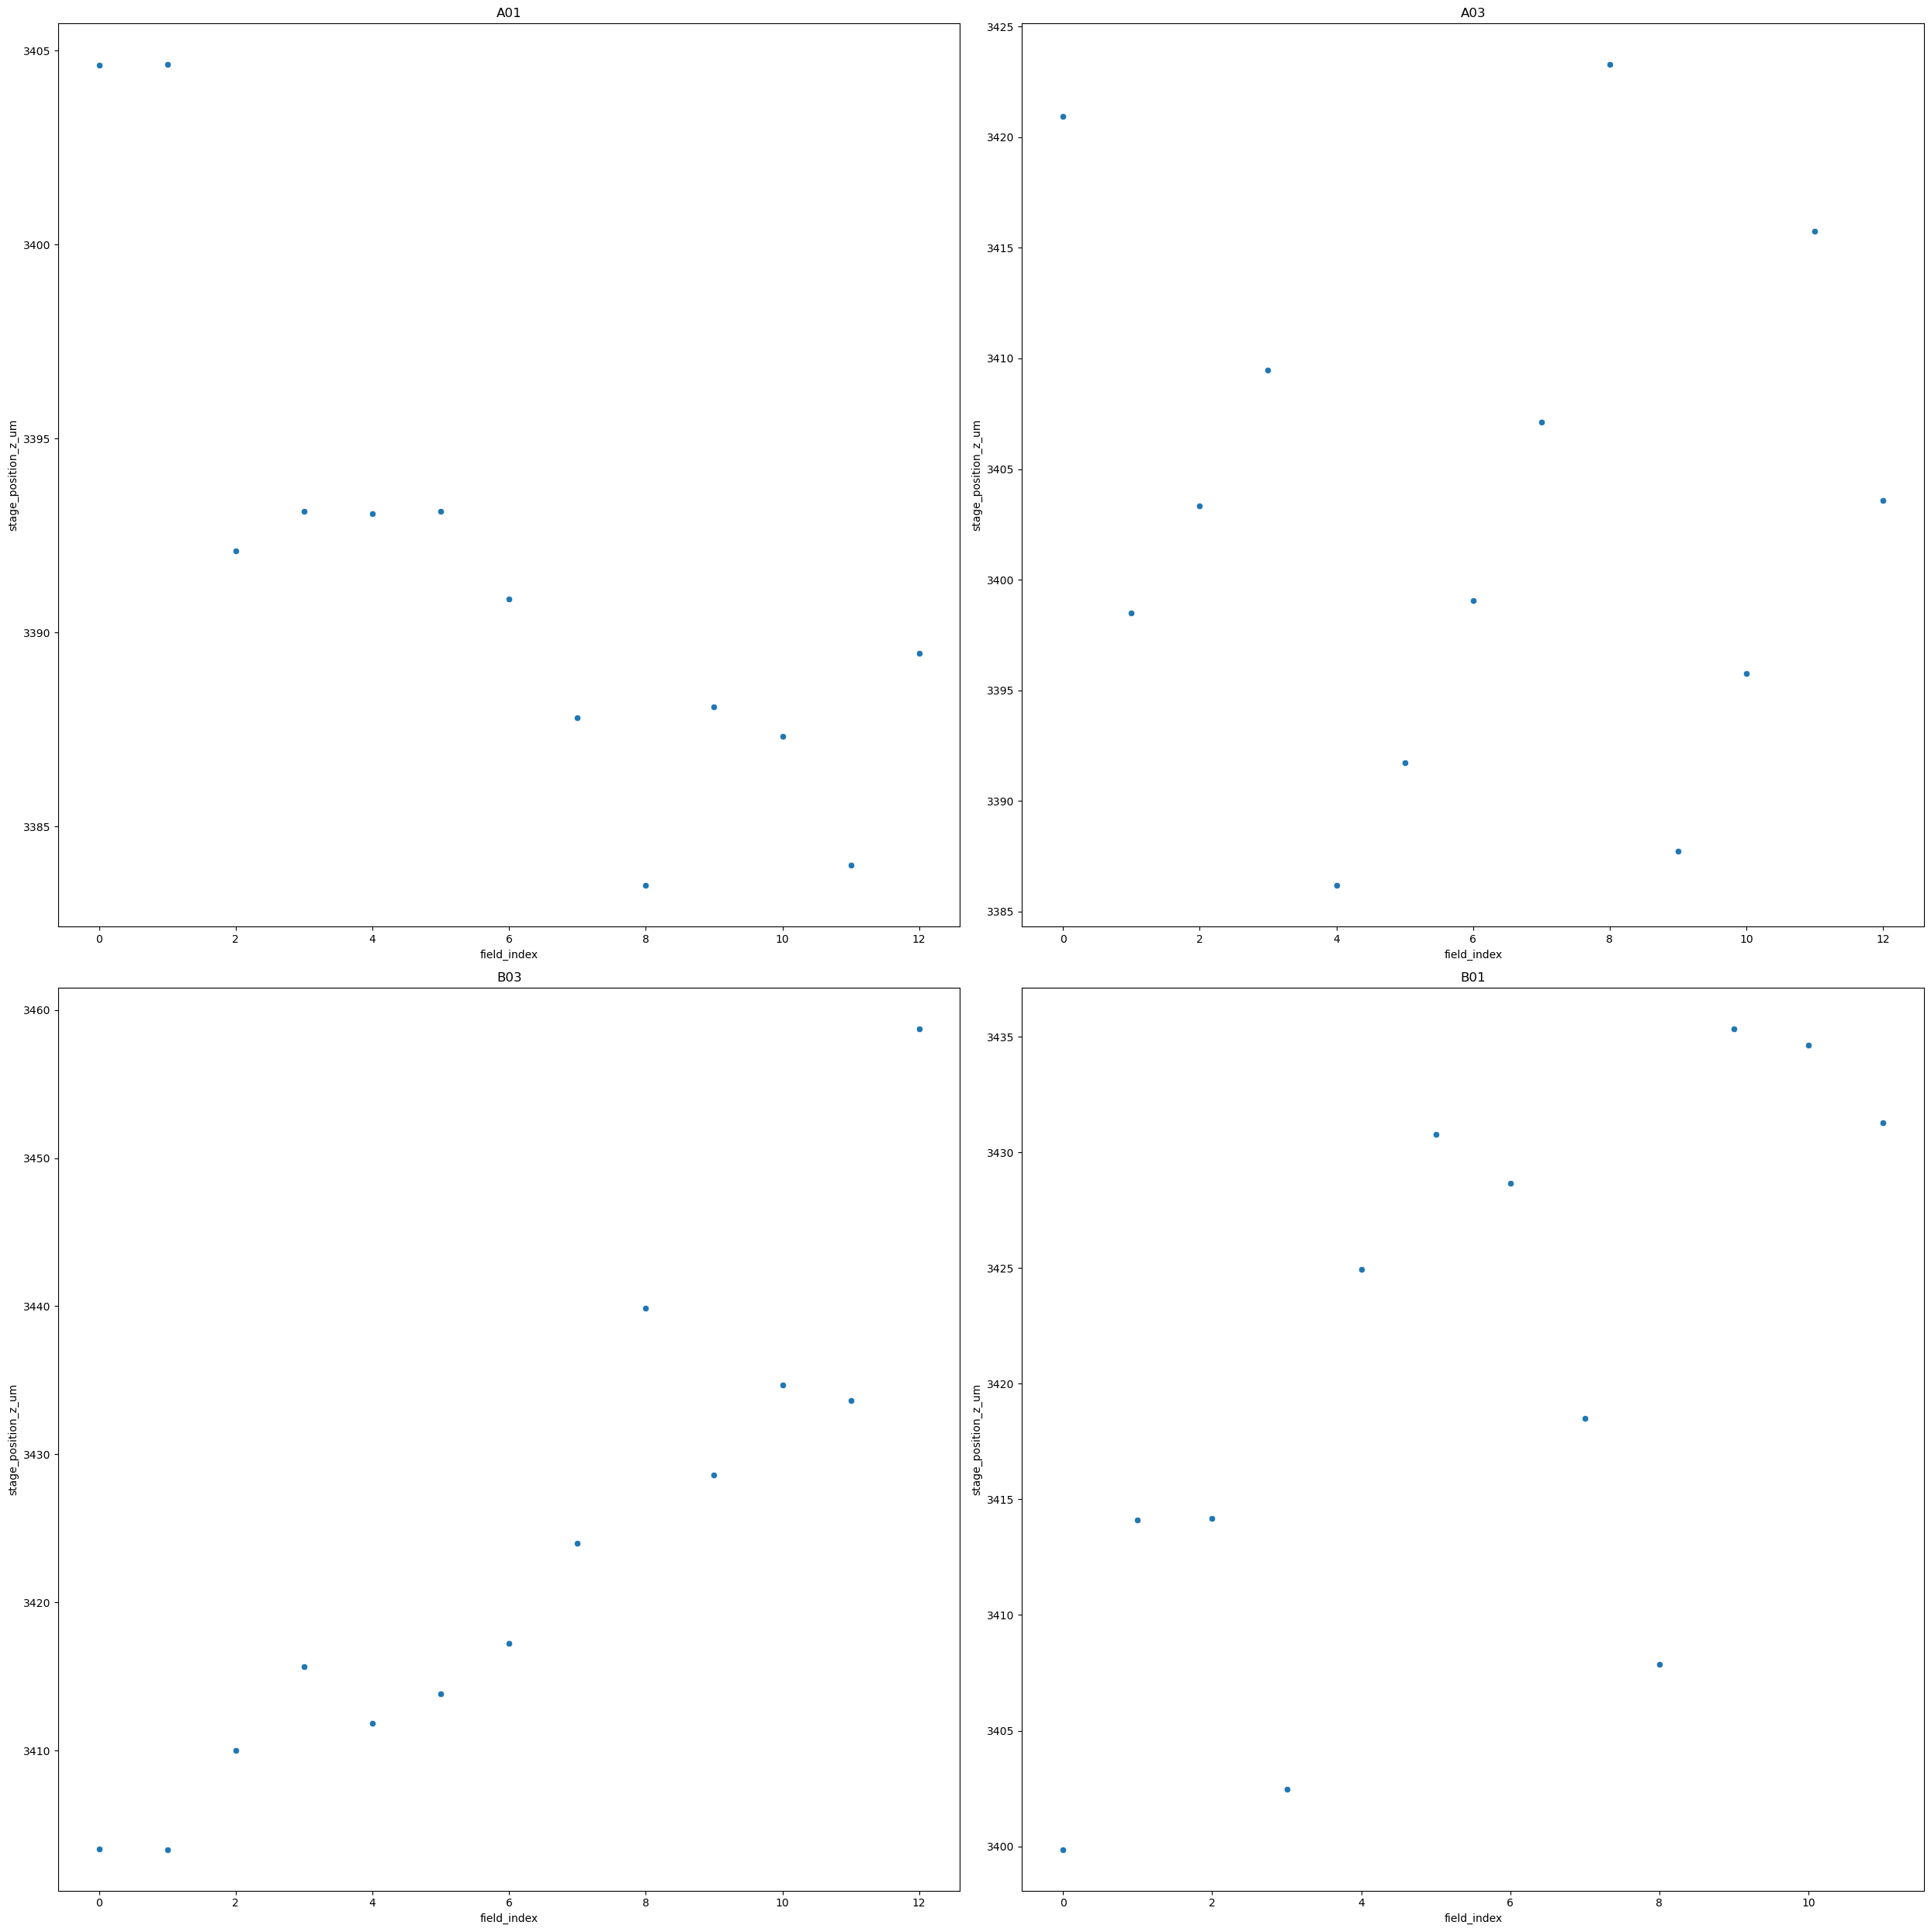

In [22]:
well_locs = MF_acquisition_df['well_loc'].unique()
cols = 2
rows = len(well_locs)//cols
fig,ax = plt.subplots(ncols = cols, nrows = rows, figsize=(25,25))
for i, well_loc in enumerate(well_locs):
    row = i//cols
    col = i%cols
    features_subset = MF_acquisition_df[MF_acquisition_df['well_loc'] == well_loc]
    sns.scatterplot(x = "field_index", y = "stage_position_z_um", data = features_subset, ax = ax[row][col]),
    ax[row][col].set_title(well_loc)   
plt.tight_layout()

In [10]:
PFS_focus = list_of_measurementsDF.loc[list_of_measurementsDF["measurement_id"] == "00050a00-1788-448f-a04e-ac1580fb6fee"]

In [19]:
PFS_focus_measurement = PFS_focus['measurement_id'].values
PFS_acquisition_df = data.create_multi_acquisition_canonical_dataframe(PFS_focus_measurement)
PFS_acquisition_df.columns

Index(['id', 'microscope_id', 'measurement_id', 'file_path',
       'raw_image_file_paths', 'time_index', 'plane_index', 'field_index',
       'plate_barcode', 'well_row', 'well_column', 'stage_position_x_um',
       'stage_position_y_um', 'stage_position_z_um',
       'stage_velocity_x_um_per_s', 'stage_velocity_y_um_per_s',
       'stage_velocity_z_um_per_s', 'created_at', 'last_updated_at',
       'pixel_size_x_um', 'pixel_size_y_um', 'image_size_x_pixels',
       'image_size_y_pixels', 'image_bit_depth', 'binning_x', 'binning_y',
       'objective_magnification', 'objective_numerical_aperture',
       'objective_immersion_medium', 'intermediate_magnification',
       'total_magnification', 'focus_maintainer_enabled',
       'focus_maintainer_offset_um', 'repeat', 'discard', 'notes', 'id_1',
       'image_id', 'widefield_fluorescence_settings_id',
       'spinning_disk_confocal_fluorescence_settings_id',
       'lamp_kohler_diascopic_settings_id',
       'unconstrained_angular_sourc

In [18]:
updated = PFS_acquisition_df[["field_index","stage_position_z_um"]]
updated

,field_index,stage_position_z_um
0,0,3375.0
1,1,3375.0
2,2,3375.0
3,3,3375.0
4,4,3375.0
...,...,...
1919,476,3375.0
1920,477,3375.0
1921,478,3375.0
1922,479,3375.0


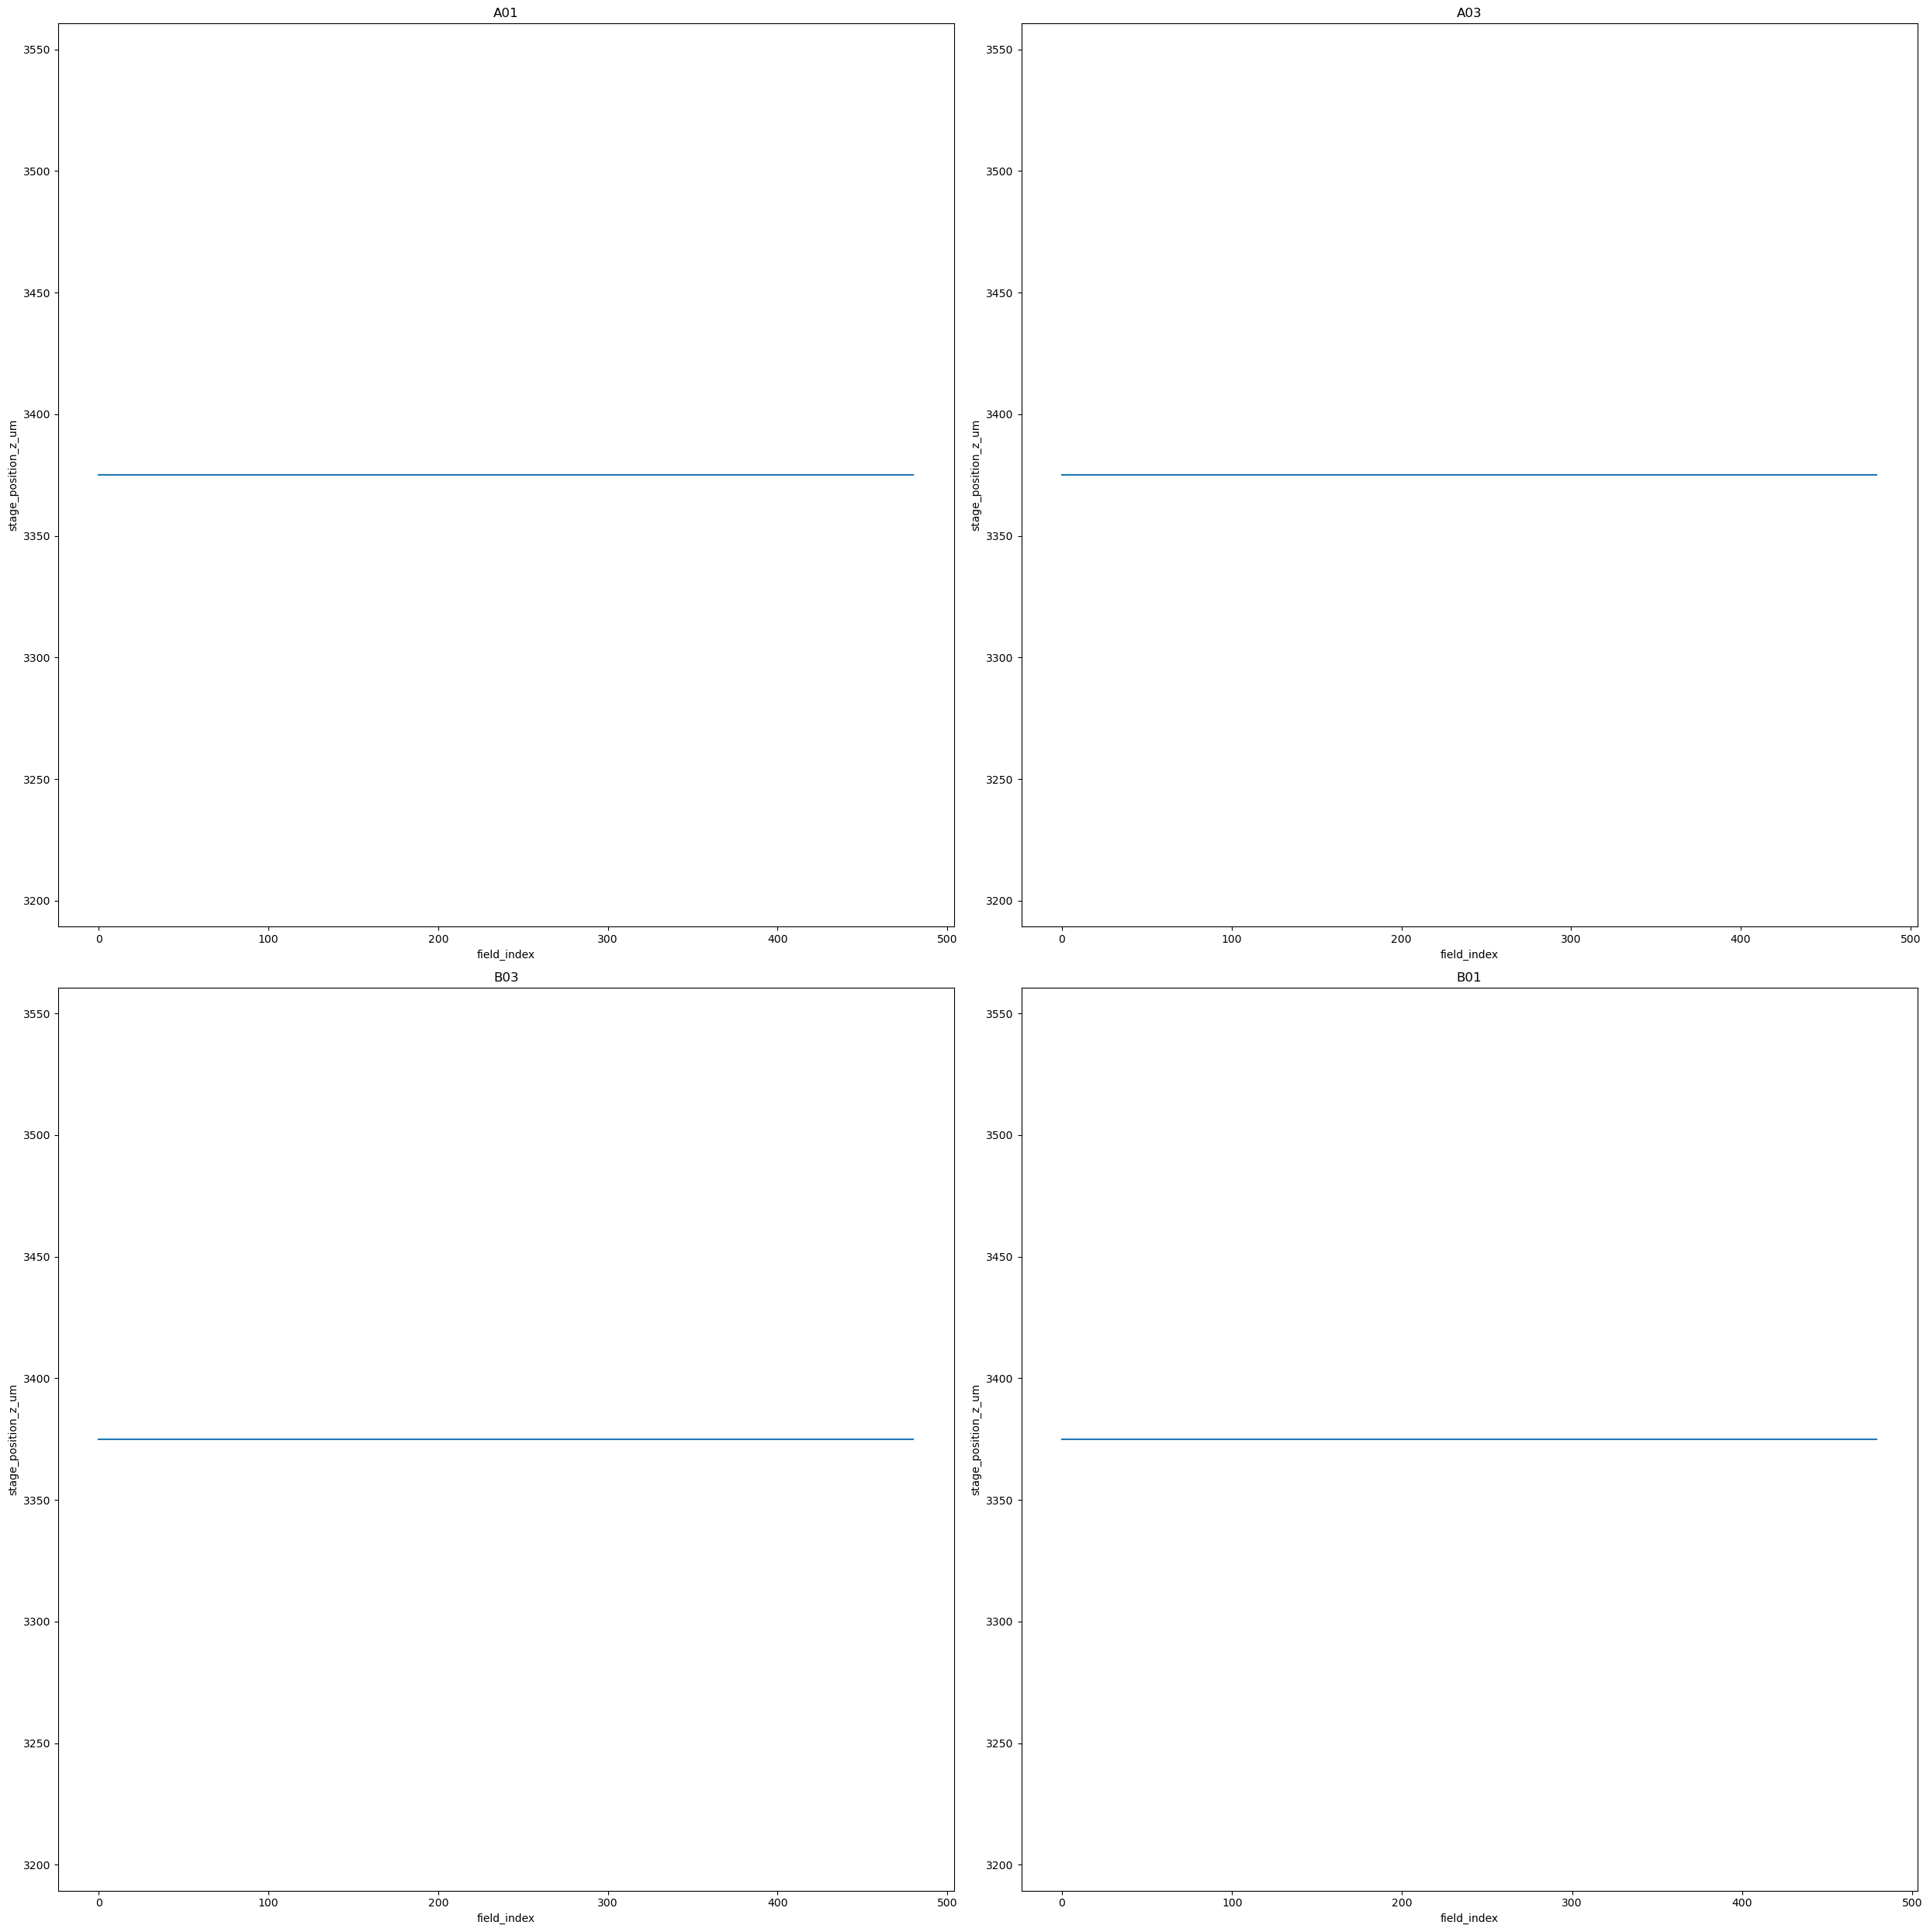

In [24]:
well_locs = PFS_acquisition_df['well_loc'].unique()
cols = 2
rows = len(well_locs)//cols 
fig,ax = plt.subplots(ncols = cols, nrows = rows, figsize=(25,25))
for i, well_loc in enumerate(well_locs):
    row = i//cols
    col = i%cols
    features_subset = PFS_acquisition_df[PFS_acquisition_df['well_loc'] == well_loc]
    sns.lineplot(x = "field_index", y = "stage_position_z_um", data = features_subset, ax = ax[row][col]),
    ax[row][col].set_title(well_loc)   
plt.tight_layout()